# 0. Install dependencies

In [9]:
 #%pip install matplotlib tensorflow==2.5.0 tensorflow-io==0.19.1 

# 1. Import depndencies 

In [10]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

In [11]:
print("tensorflow version:", tf.__version__)
print("tensorflow_io version:", tfio.__version__)

tensorflow version: 2.5.0
tensorflow_io version: 0.19.1


# 2. Loading data

In [12]:
# Here we are loding only one file for testing purpose

CRY_FILE = os.path.join('data', 'cry', 'baby_cry (366).wav')
NOT_CRY_FILE = os.path.join('data', 'not_cry', 'noise (149).wav')

In [13]:
print(CRY_FILE)
print(NOT_CRY_FILE)

data\cry\baby_cry (366).wav
data\not_cry\noise (149).wav


# 3. Data loading function

In [14]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# 4. Plotting waveform

In [15]:
wave = load_wav_16k_mono(CRY_FILE)
nwave = load_wav_16k_mono(NOT_CRY_FILE)

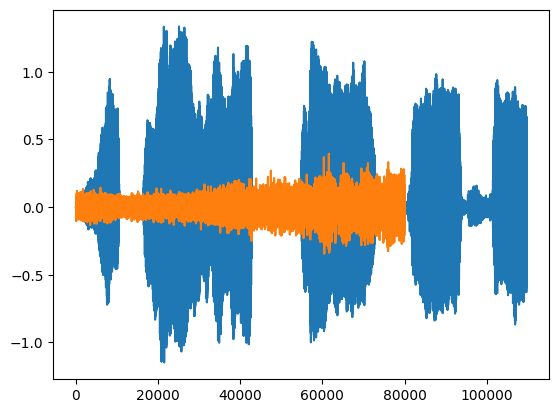

In [16]:
plt.plot(wave) # Blue waveform
plt.plot(nwave) # Orange waveform
plt.show()

# 5. Creating Tensorflow Dataset

In [17]:
# Defining paths to positive and negative data

POS = os.path.join('data', 'cry')
NEG = os.path.join('data', 'not_cry')